# Assignment 3

You only need to write one line of code for each question. When answering questions that ask you to identify or interpret something, the length of your response doesn’t matter. For example, if the answer is just ‘yes,’ ‘no,’ or a number, you can just give that answer without adding anything else.

We will go through comparable code and concepts in the live learning session. If you run into trouble, start by using the help `help()` function in Python, to get information about the datasets and function in question. The internet is also a great resource when coding (though note that **no outside searches are required by the assignment!**). If you do incorporate code from the internet, please cite the source within your code (providing a URL is sufficient).

Please bring questions that you cannot work out on your own to office hours, work periods or share with your peers on Slack. We will work with you through the issue.

### Clustering and Resampling

Let's set up our workspace and use the **Wine dataset** from `scikit-learn`. This dataset is a classic dataset used for clustering tasks. It consists of many samples of wine. Here are the key features and characteristics of the dataset:

##### Features (13 chemical properties):
1. Alcohol: The percentage of alcohol in the wine.
2. Malic acid: A type of acid found in grapes, contributing to wine’s tartness.
3. Ash: The total amount of non-volatile substances left after burning the wine
4. Alcalinity of ash: Measures the alkalinity of the ash component of wine.
5. Magnesium: The amount of magnesium in the wine (measured in mg/L).
6. Total phenols: Represents the total amount of phenolic compounds in wine.
7. Flavanoids: A type of phenolic compound responsible for bitterness and astringency.
8. Nonflavanoid phenols: Phenolic compounds that are not flavonoids.
9. Proanthocyanins: A type of tannin that affects astringency and bitterness.
10. Color intensity: Measures the depth or intensity of the wine’s color. 
11. Hue: The shade of color in the wine (ratio of red to yellow tones).
12. OD280/OD315 of diluted wines: Measures the wine’s absorbance at 280 nm and 315 nm, indicating phenol concentration.
13. Proline: An amino acid found in wine, often associated with aging potential and quality.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


#### **Question 1:** 
#### Data inspection

#### Load the Wine dataset:

Use scikit-learn to load the Wine dataset and convert it into a Pandas DataFrame.
Display the first few rows of the dataset. How many observations (rows) and features (columns) does the dataset contain?

In [2]:
from sklearn.datasets import load_wine
# Load the Wine dataset
wine_data = load_wine()

# Convert to DataFrame
wine_df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)

# Display the DataFrame
print(wine_df)

# Your code here...

num_observations, num_features = wine_df.shape

print(f"\nNumber of observations (rows): {num_observations}")
print(f"Nmber of features (columns): {num_features}")

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyan

#### **Question 2:** 
#### Data-visualization

Let's create plots to visualize the relationships between the features (e.g., alcohol, malic acid, ash...).


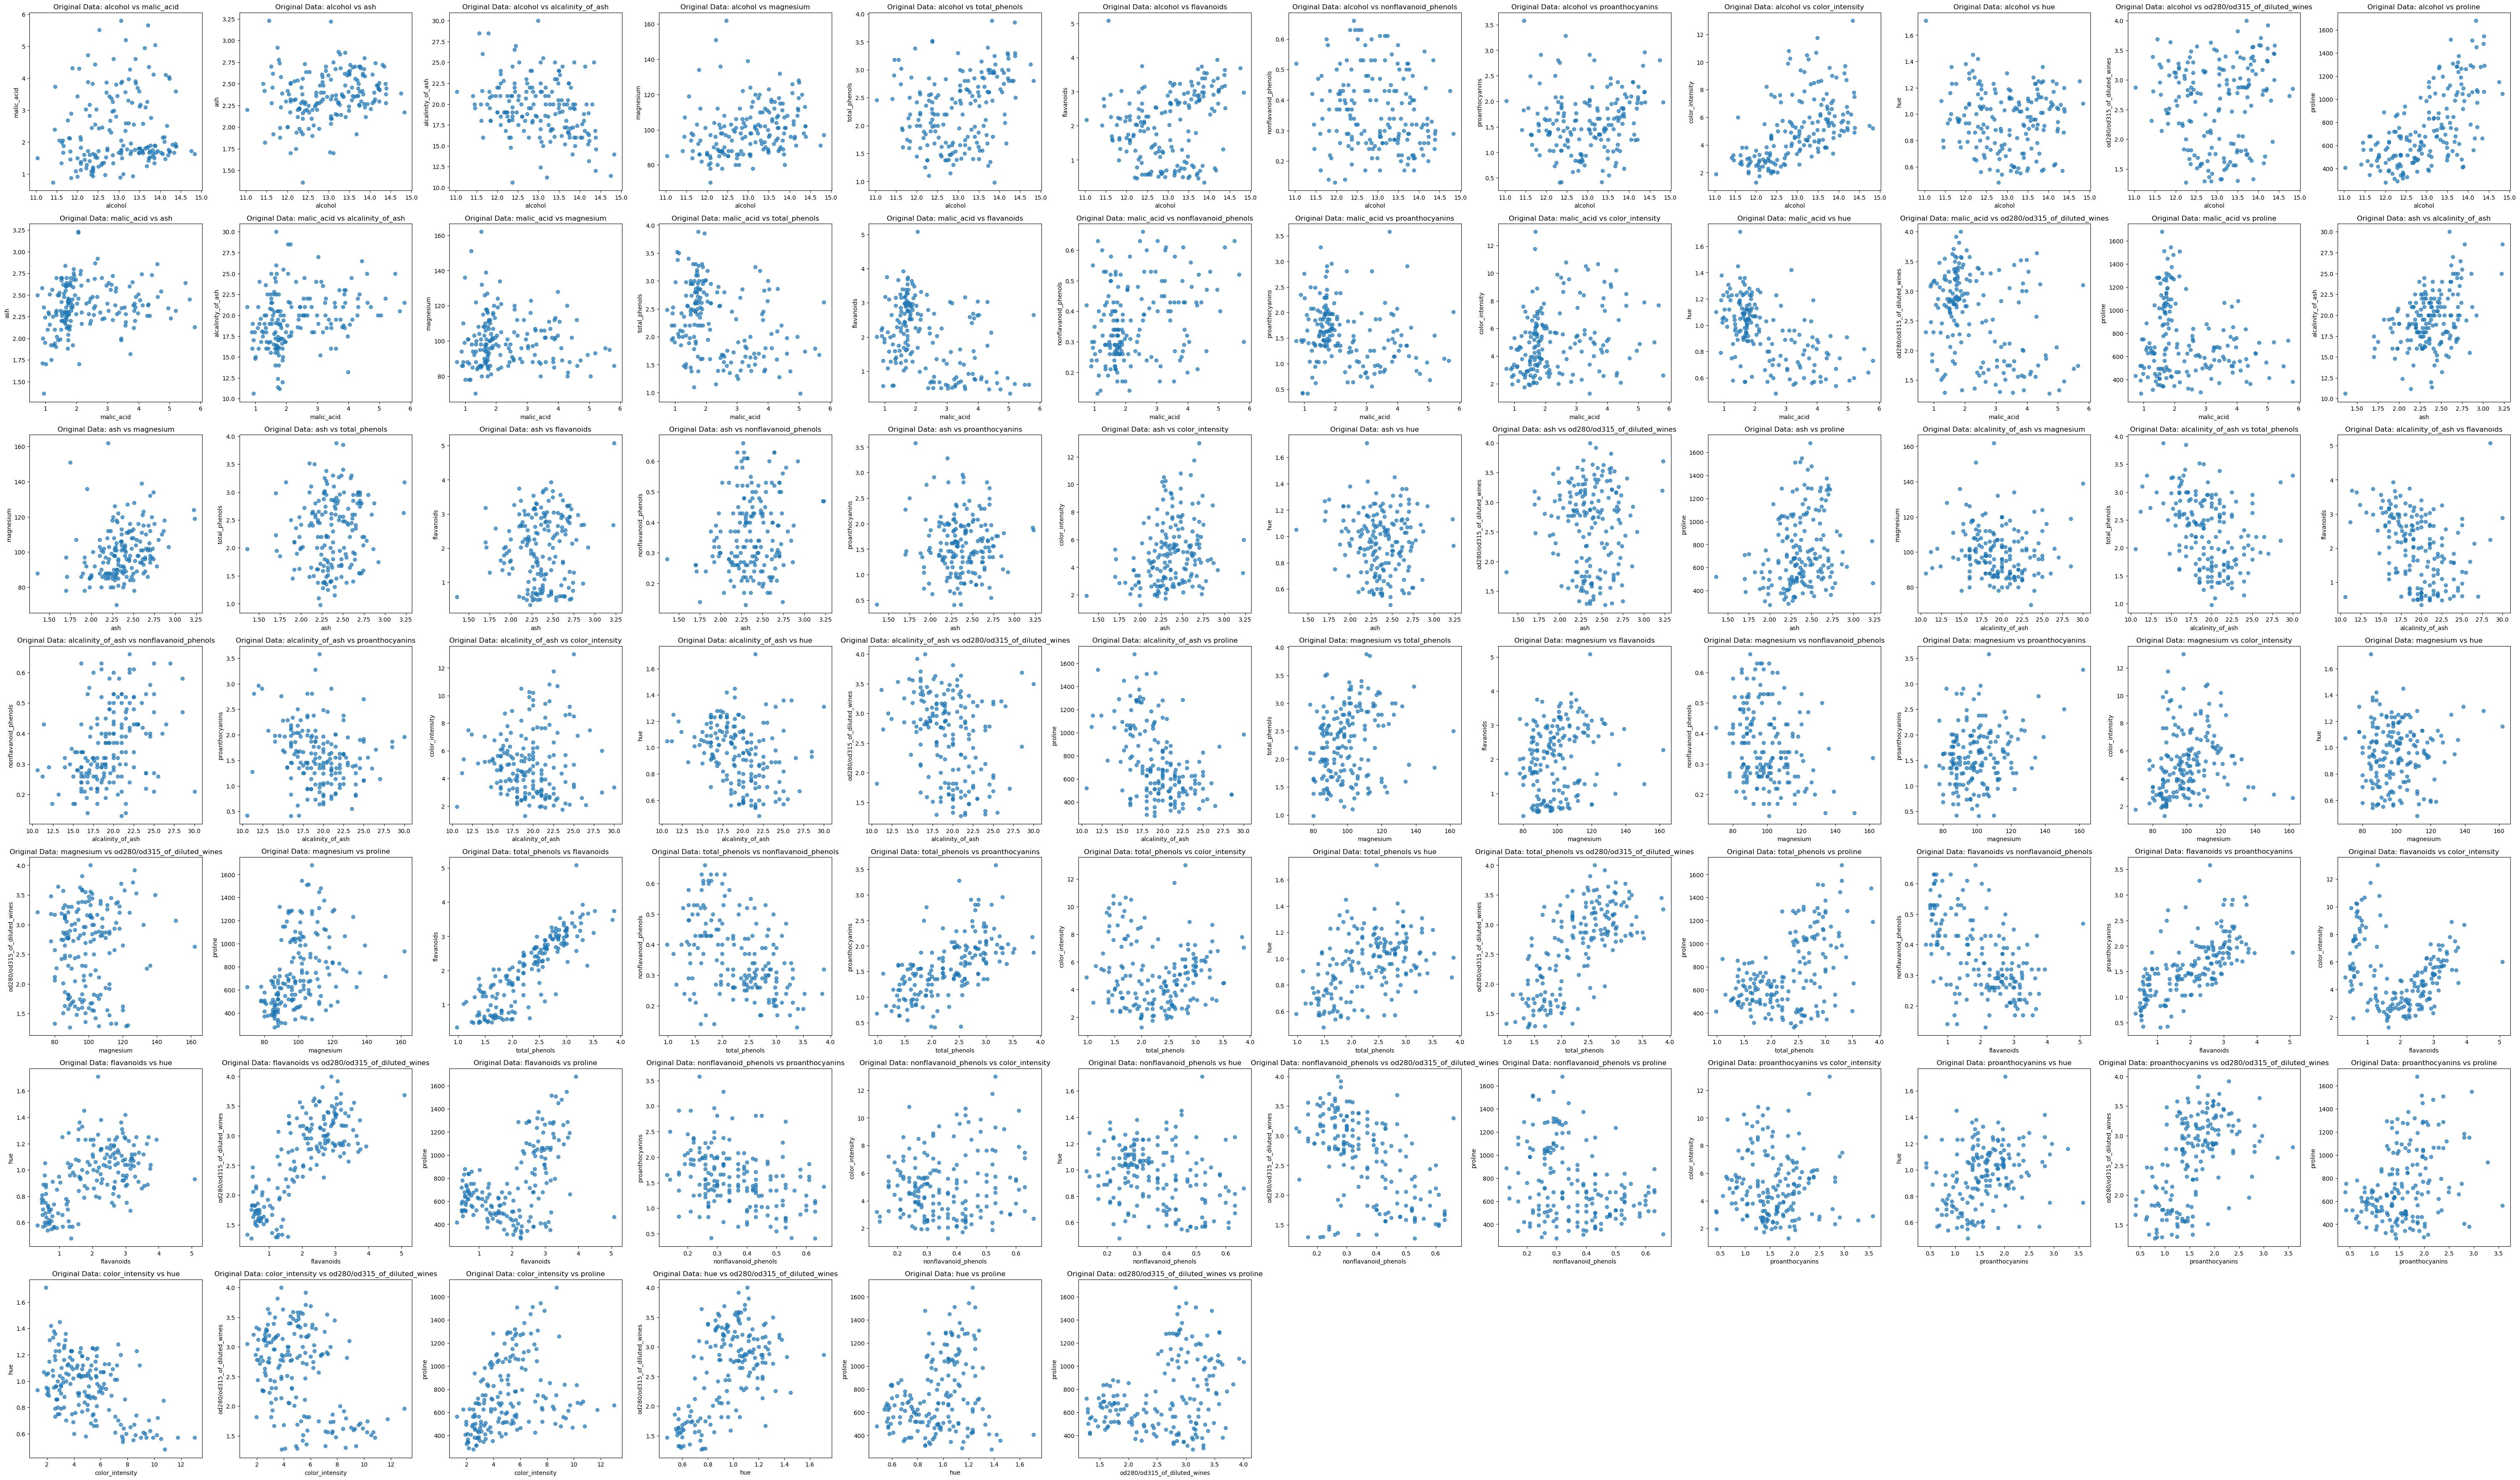

In [3]:
def plot_feature_pairs(data, feature_names, color_labels=None, title_prefix=''):
    """
    Helper function to create scatter plots for all possible pairs of features.
    
    Parameters:
    - data: DataFrame containing the features to be plotted.
    - feature_names: List of feature names to be used in plotting.
    - color_labels: Optional. Cluster or class labels to color the scatter plots.
    - title_prefix: Optional. Prefix for plot titles to distinguish between different sets of plots.
    """
    # Create a figure for the scatter plots
    plt.figure(figsize=(60, 60))
    
    # Counter for subplot index
    plot_number = 1
    
    # Loop through each pair of features
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            plt.subplot(len(feature_names)-1, len(feature_names)-1, plot_number)
            
            # Scatter plot colored by labels if provided
            if color_labels is not None:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], 
                            c=color_labels, cmap='viridis', alpha=0.7)
            else:
                plt.scatter(data[feature_names[i]], data[feature_names[j]], alpha=0.7)
            
            plt.xlabel(feature_names[i])
            plt.ylabel(feature_names[j])
            plt.title(f'{title_prefix}{feature_names[i]} vs {feature_names[j]}')
            
            # Increment the plot number
            plot_number += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Get feature names
feature_names = wine_df.columns

# Use the helper function to plot scatter plots without coloring by cluster labels
plot_feature_pairs(wine_df, feature_names, title_prefix='Original Data: ')

In [4]:
# Finding Correlation
correlation_matrix = wine_df.corr(method='pearson')
threshold = 0.7
highly_correlated_mask = (np.abs(correlation_matrix) >= threshold) & (correlation_matrix != 1.0)
high_correlations_filtered = correlation_matrix[highly_correlated_mask]
high_correlations_list = high_correlations_filtered.stack().sort_values(ascending=False)
print(high_correlations_list)

total_phenols                 flavanoids                      0.864564
flavanoids                    total_phenols                   0.864564
                              od280/od315_of_diluted_wines    0.787194
od280/od315_of_diluted_wines  flavanoids                      0.787194
dtype: float64


**Question:**
- Do you notice any patterns or relationships between the different features? How might these patterns help in distinguishing between different species?

The plot is a great visual cue to understand correlation but to come to a definitive conclusion we need numbers. From the plot we can see linear relationships, nonlinear relationships, clustering(tight clustering and sparse clustering). We can use this information to distinguish features through feature importance, decision boundaries, and clustering into different groups. From the above correlation matrix filter with a threshold of 0.7, we can observe a strong positive correlation between "total_phenols and flavanoids" (0.86) and "od315 of duluted wines and flavanoids" have a high correlation (0.78).

#### **Question 3:** 
#### Data cleaning

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale all the features in the dataset
scaled_features = scaler.fit_transform(wine_df)

# Create a new DataFrame with scaled features
scaled_wine_df = pd.DataFrame(scaled_features, columns=wine_data.feature_names)

# Display the first few rows of the scaled DataFrame
print(scaled_wine_df.head())

    alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  
0         0.251717  0.362177                      1.847920  1.013009  
1        -0.293321  0.406051

Why is it important to standardize the features of a dataset before applying clustering algorithms like K-Means? Discuss the implications of using unstandardized data in your analysis.

Its important to do feature scaling so we can avoid features with larger scales from dominating. If clusters are formed on arbitraty scales then our centroid will be heavily influenced by these features and our result will not be optimal.

#### **Question 4:** 
#### K-means clustering 

Apply the K-Means clustering algorithm to the Wine dataset. Choose the value 3 for the number of clusters (`k=3`) and fit the model. Assign cluster labels to the original data and add them as a new column in the DataFrame.

First 5 rows of clustered_wine_data with cluster labels:
    alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   o

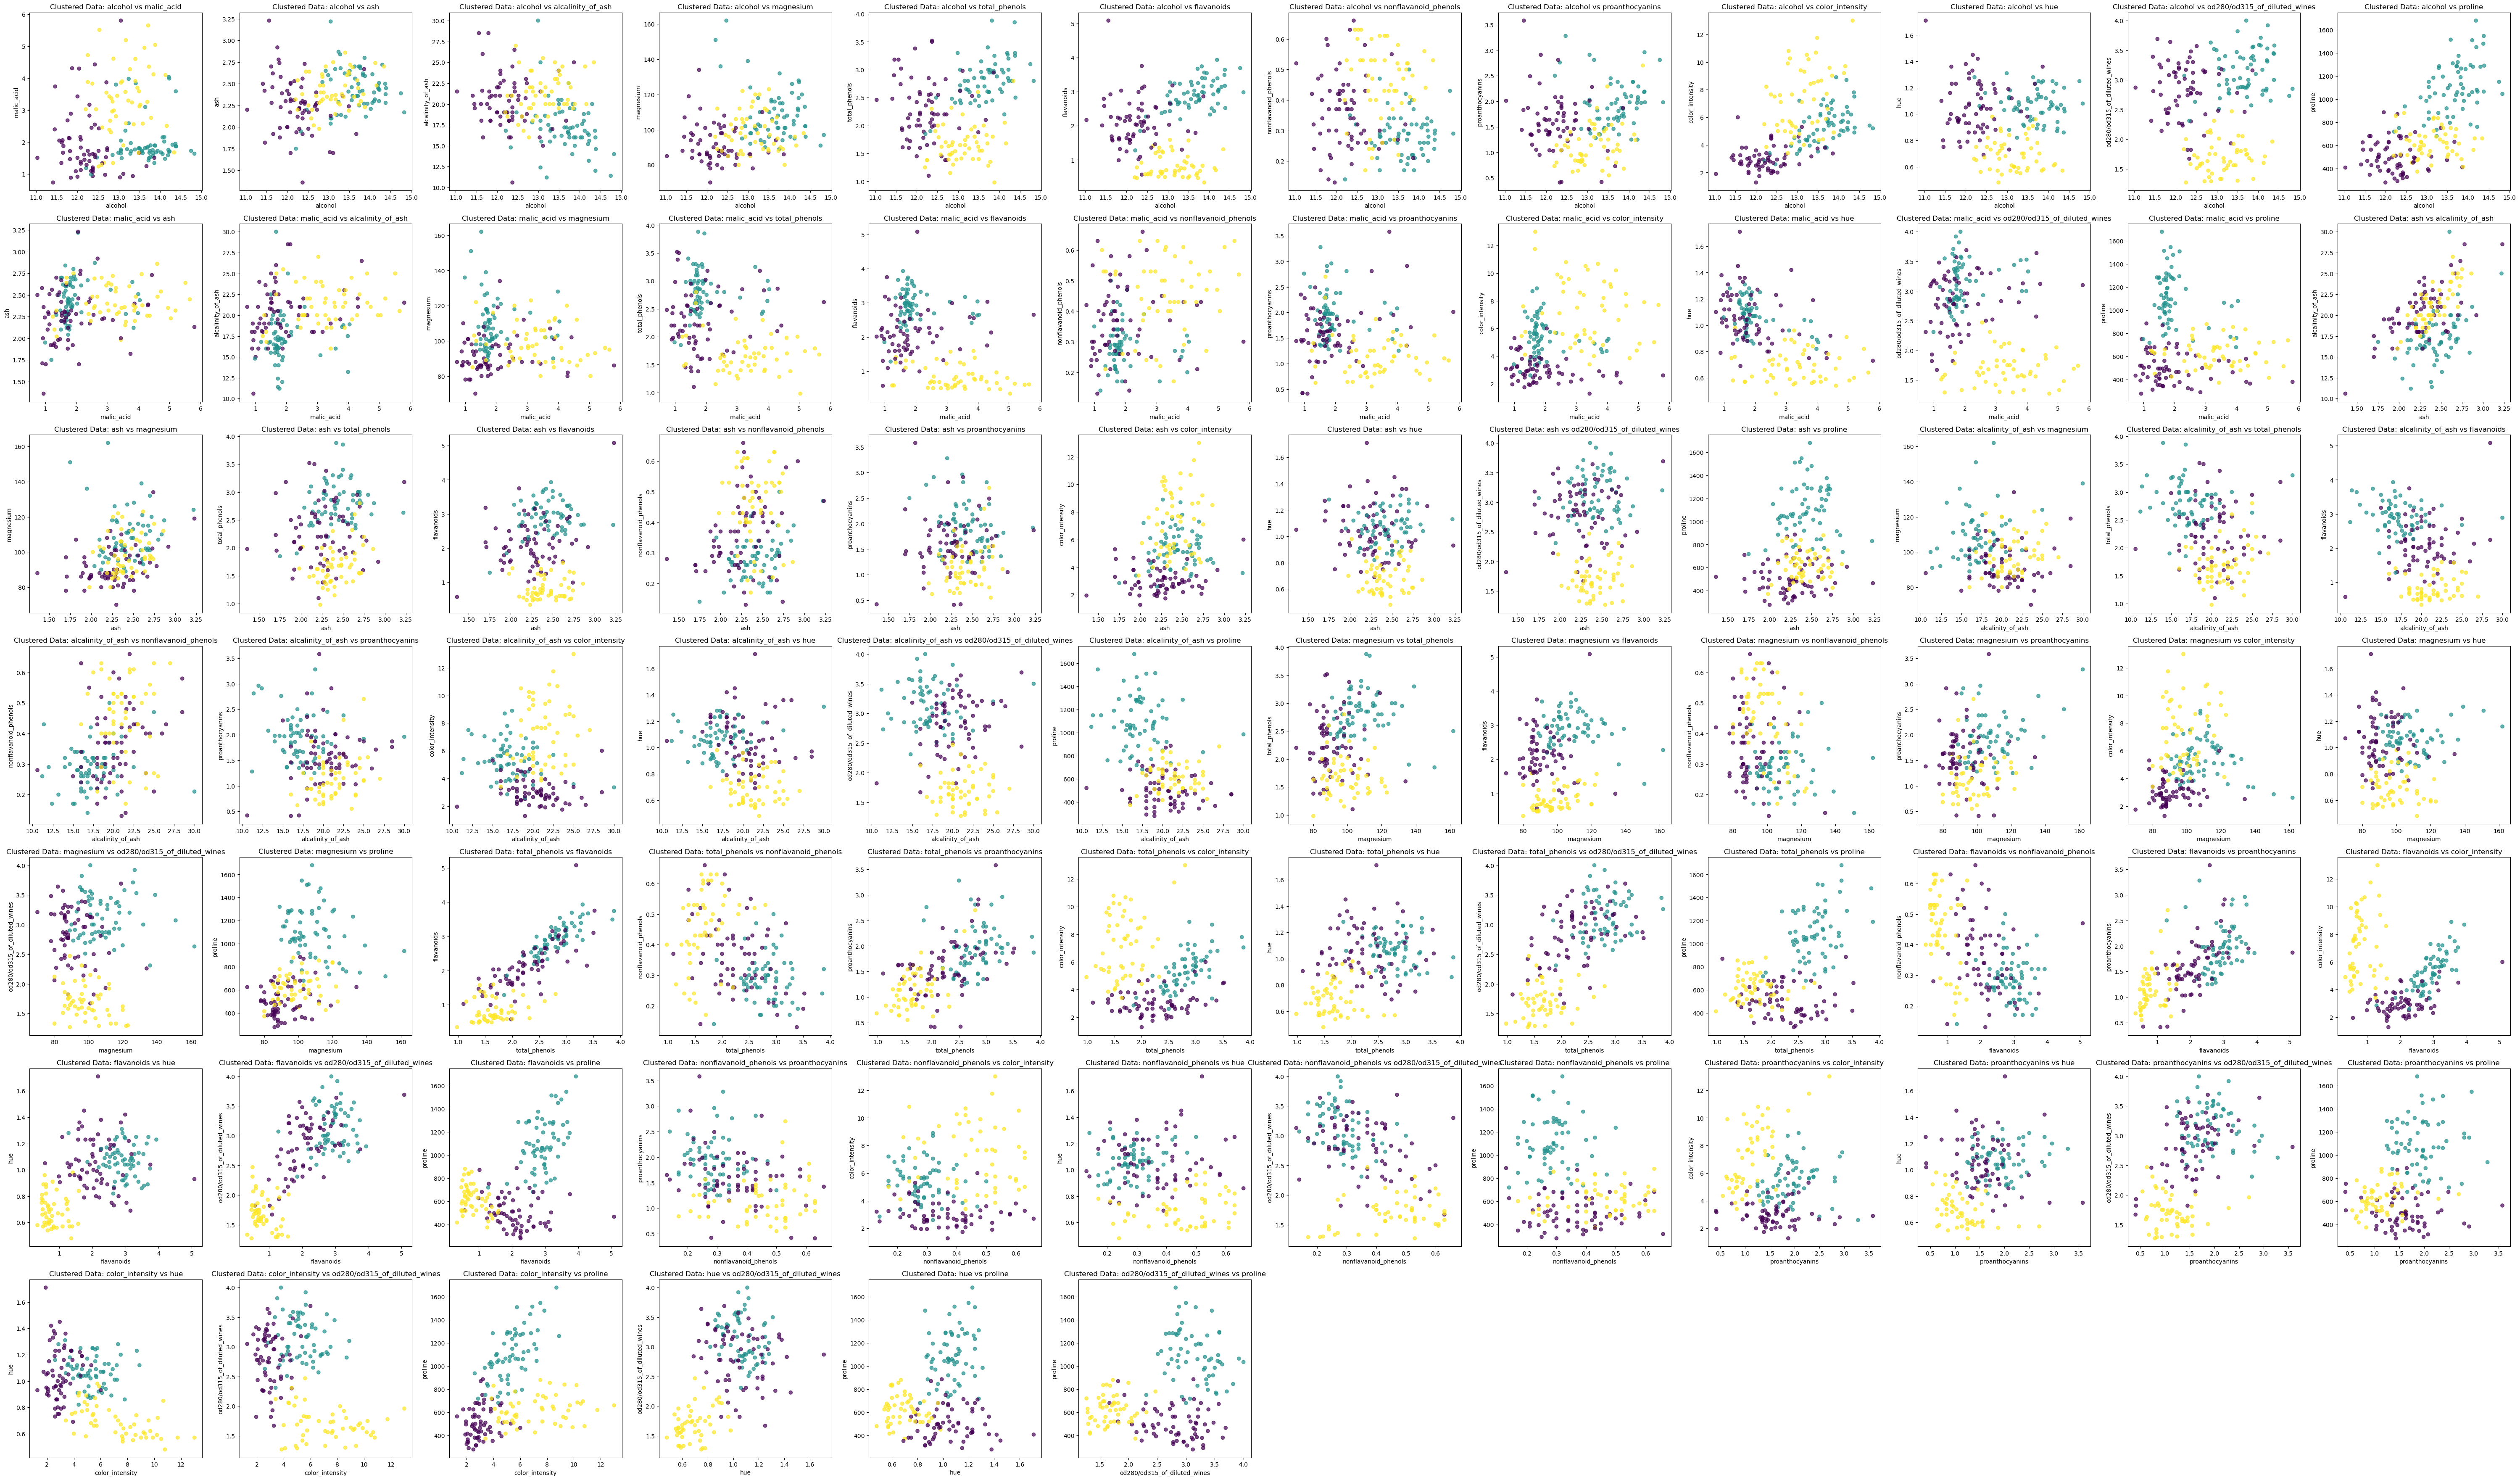

In [6]:
# Your answer...
# Applying Kmeans
k = 3

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')

kmeans.fit(scaled_wine_df)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assigning cluster labels to original data
clustered_wine_data = wine_df.copy()
clustered_wine_data['Cluster'] = cluster_labels

print("First 5 rows of clustered_wine_data with cluster labels:\n", clustered_wine_data.head())
print("\nCluster distribution (number of observations per cluster):\n", clustered_wine_data['Cluster'].value_counts())

# Use the helper function to plot scatter plots, colored by cluster labels
plot_feature_pairs(clustered_wine_data, feature_names, color_labels=clustered_wine_data['Cluster'], title_prefix='Clustered Data: ')

We chose `k=3` for the number of clusters arbitrarily. However, in a real-world scenario, it is important to determine the optimal number of clusters using appropriate methods.

**Question**: What is one method commonly used to determine the optimal number of clusters in K-means clustering, and why is this method helpful?

We can use the Elbow method to find K. When we plot the withincluster sum of squared(inertia) aginst the clusters (k), the eblow is the point on the curve where increasing the clusters will give diminishing returns. Increasing K will complicate the model (too many clusters with no meaning ful split)so we use this mehtod to find that optimal point.

#### **Question 5:** 
#### Bootstrapping 

Implement bootstrapping on the mean of `color intensity`. Generate 10000 bootstrap samples, calculate the mean for each sample, and compute a 90% confidence interval.

Mean of Color Intensity: 5.058089882022472
90% Confidence Interval of Mean Color Intensity: (4.7881629160112364, 5.347780882584269)


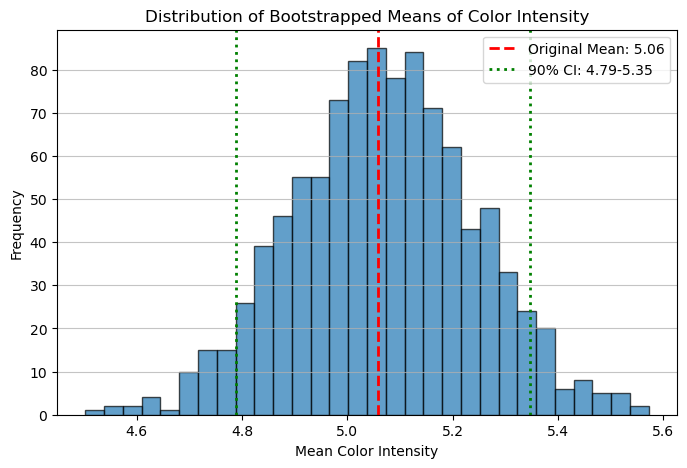

In [7]:
# Your answer here...

mean_color_intensity = wine_df['color_intensity'].mean()

np.random.seed(123)

# NUmber of bootstrap samples
n_bootstrap_samples = 1000

bootstrapped_means = []

# Performing bootstrap

for _ in range(n_bootstrap_samples):
    # Resampling with replacement
    bootstrap_sample = wine_df['color_intensity'].sample(n=len(wine_df), replace=True)
    # Calculate mean of the bootstrap sample
    bootstrapped_means.append(bootstrap_sample.mean())

# Convereting to an nparray for easier calculation  
bootstrapped_means = np.array(bootstrapped_means)

# Calculate the confidence interval using percentile menthod

lower_bound = np.percentile(bootstrapped_means, 5) # 5th percentile for lower bound of 90% CI
upper_bound = np.percentile(bootstrapped_means, 95) # 95th percentil for upperbound of 90% CI

# Display the result
print(f"Mean of Color Intensity: {mean_color_intensity}")
print(f"90% Confidence Interval of Mean Color Intensity: ({lower_bound}, {upper_bound})")

plt.figure(figsize=(8, 5))
plt.hist(bootstrapped_means, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_color_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Original Mean: {mean_color_intensity:.2f}')
plt.axvline(lower_bound, color='green', linestyle='dotted', linewidth=2, label=f'90% CI: {lower_bound:.2f}-{upper_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='dotted', linewidth=2)
plt.title('Distribution of Bootstrapped Means of Color Intensity')
plt.xlabel('Mean Color Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

**Question:**
- Why do we use bootstrapping in this context? What does it help us understand about the mean?

Bootstrapping gives a non-parametric way of estimating the precision and reliability of an estimator derived from our limited data. By repeated sampling with replacment from out existing data and recalculating the mean from each bootstrap sample, we generate many possible means and this spread of means gives us an idea of how much our calculated mean might vary if we were to draw different samples from true population.

**Question:**
- What is the purpose of calculating the confidence interval from the bootstrap samples? How does it help us interpret the variability of the estimate?

The purpose of calculating confidence interval from bootstrap samples is to povide a range of plausible values for the true population parameter. It quantifies how certain or uncertain we are about our estimate. A 90% CI tells us that if we repeat this process then construct the confidence interval then 90% of those will contain the true population mean.

**Question:**

- Reflect on the variability observed in the bootstrapped means and discuss whether the mean of the color intensity appears to be a stable and reliable estimate based on the confidence interval and the spread of the bootstrapped means.

The 90% confidence interval for the mean of color_intensity is (4.78, 5.34). Interval range is 5.34-4.78 = 0.56. It suggests the samples are tightly clustered around the sample mean(color_intensit) of 5.05. If the bootstrapped means were variable then the confidence interva would be wider. Since estmate is narrow we can conclude that color_intensity to be a robust and reliable estimate.

# Criteria


| **Criteria**                                           | **Complete**                                      | **Incomplete**                                    |
|--------------------------------------------------------|---------------------------------------------------|--------------------------------------------------|
| **Data Inspection**                                    | Data is thoroughly inspected for the number of variables, observations, and data types, and relevant insights are noted. | Data inspection is missing or lacks detail.         |
| **Data Visualization**                                 | Visualizations (e.g., scatter plots) are correctly interpreted to explore relationships between features and species. | Visualizations are not correctly interpreted. |
| **Clustering Implementation**                           | K-Means clustering is correctly implemented, and cluster labels are appropriately assigned to the dataset.            | K-Means clustering is missing or incorrectly implemented. |
| **Bootstrapping Process**                              | Bootstrapping is correctly performed, and results are used to assess variable mean stability. | Bootstrapping is missing or incorrectly performed. |

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Note:

If you like, you may collaborate with others in the cohort. If you choose to do so, please indicate with whom you have worked with in your pull request by tagging their GitHub username. Separate submissions are required.

### Submission Parameters:
* Submission Due Date: `11:59 PM - 06/01/2025`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/LCR/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
